# PyART示例

演示使用python开源pyart雷达数据处理库国内S波段雷达数据

In [1]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature  

import pyart
from pyart.io.sband_archive import read_sband_archive


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/tools/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


读取雷达数据，在读取雷达数据时可以给定所使用雷达的经纬度坐标以及高度信息，此信息可以通过 read_sband_archive 函数的
station 参数指定，给定经纬度坐标和高度信息时，通过 (lat, lon, height) python 元组给出上述信息，不给出此信息时 
station 默认为 None。如给出的 station 不满足上述要求则会出错。

### 以下是示例:

In [2]:
filename = "Z_RADR_I_Z9515_20160623063100_O_DOR_SA_CAP.bin"
radar = read_sband_archive(filename, station=(33.431, 120.201, 80))

/usr/local/tools/anaconda3/lib/python3.6/site-packages/pyart/io/sband_archive.py:183: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


pyart 库中提供了一些绘图函数，可以直接使用内置的绘图函数绘制雷达反射率

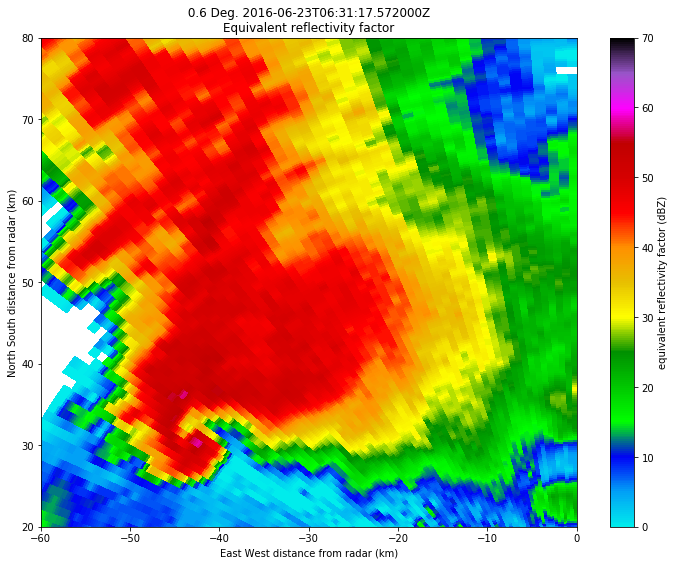

In [3]:
fig, ax = plt.subplots(figsize=(12, 9))

display = pyart.graph.radardisplay.RadarDisplay(radar)
display.plot_ppi("reflectivity", 0, vmin=0, vmax=70)

ax.set_xlim([-60, 0])
ax.set_ylim([20, 80])

plt.show()

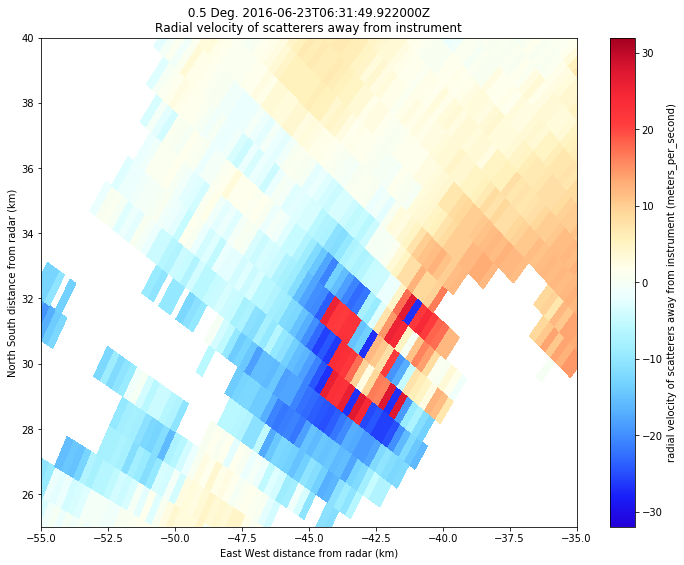

In [4]:
fig, ax = plt.subplots(figsize=(12, 9))

display = pyart.graph.radardisplay.RadarDisplay(radar)
display.plot_ppi("velocity", 1, vmin=-32, vmax=32)
ax.set_xlim([-55, -35])
ax.set_ylim([25, 40])

plt.show()

如果给定了雷达站点的经纬度信息时，还可以利用pyart内置的相关函数添加地理信息

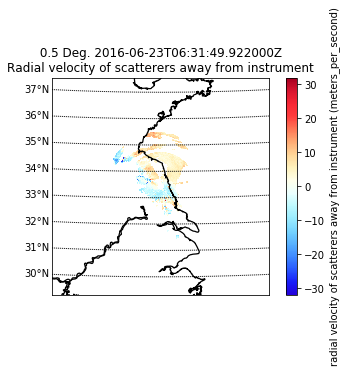

In [5]:
# 使用 basemap

fig, ax = plt.subplots()

display = pyart.graph.radarmapdisplay.RadarMapDisplay(radar)
display.plot_ppi_map("velocity", 1, vmin=-32, vmax=32)

plt.show()

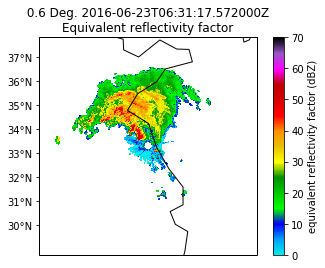

In [6]:
# 使用 cartopy

fig, ax = plt.subplots()

display = pyart.graph.radarmapdisplay_cartopy.RadarMapDisplayCartopy(radar)
display.plot_ppi_map("reflectivity", 0, vmin=0, vmax=70)

plt.show()

如果不使用pyart内置的函数绘图时，可以直接获取相关的数据，自行绘图或者进行其它操作，以下是获取数据的相关操作:

radar 对象有一些方法可以获取经纬度信息(需要在处理数据时给定雷达站点经纬度坐标)或者每个像素点距离雷达站点的距离，
因为返回的 lazydict.LazyLoadDict，因此先查看关键词:

In [7]:
for i in radar.gate_latitude.keys():
    print(i)

long_name
units
data


由上述输出发现，其中包含了三个关键词，而数据包含在 data 中

In [8]:
sweep = 0

下面获取经纬度，高度以及底层雷达基本反射率

In [9]:
lat = radar.gate_latitude.get('data')[radar.get_start(sweep):radar.get_end(sweep)+1, :]
lon = radar.gate_longitude.get('data')[radar.get_start(sweep):radar.get_end(sweep)+1, :]
height = radar.gate_altitude.get('data')[radar.get_start(sweep):radar.get_end(sweep)+1, :]

In [10]:
ref = radar.get_field(0, 'reflectivity').data[:, :]

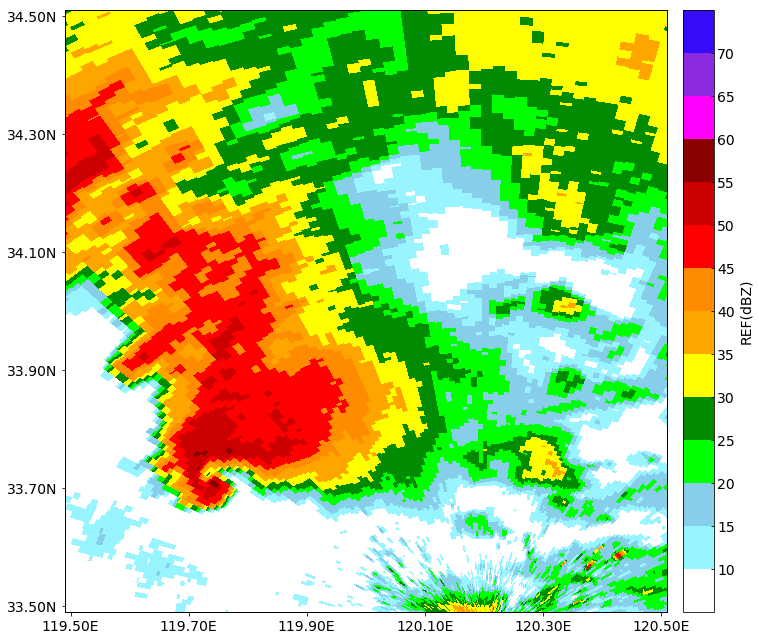

In [11]:
from matplotlib import colors

proj = ccrs.PlateCarree()

ft = 14

## 自定义 colormap
#colev = ["#89309F", "#563992", "#6A63AA", "#77A9C0", "#48A430", "#82C670", "#AADFA7", "#E5E5E5",
#         "#F2B447", "#D59A48", "#B27E4E", "#976859", "#D5627C", "#DC4F6D", "#C12C43"]

colev = ["#FFFFFF", "#98F5FF", "#87CEEB", "#00FF00", "#008B00", "#FFFF00", "#FFA500", 
         "#FF8C00", "#FF0000", "#CD0000", "#8B0000", "#FF00FF", "#8A2BE2", "#360CF9"]

cmaps = colors.ListedColormap(colev, "indexed")  

## axes 
xmin = 119.5
xmax = 120.5
ymin = 33.5
ymax = 34.5
xstep = 0.2
ystep = 0.2


ref[ref <= -32] = np.nan
#velocity[velocity <= -64] = np.nan

## 开始绘图
fig, ax = plt.subplots(figsize=(12, 9),
                       subplot_kw=dict(projection=proj)
                      )

pc=ax.pcolor(lon, lat, ref, cmap=cmaps, vmin=5, vmax=75)

## axes 设置
ax.set_xlim([xmin - 0.01, xmax + 0.01])
ax.set_ylim([ymin - 0.01, ymax + 0.01])

ax.set_xticks(np.arange(xmin, xmax + 0.01, xstep))
ax.set_yticks(np.arange(ymin, ymax + ystep/2, ystep))

ax.set_xticklabels(np.arange(xmin, xmax + 0.01, xstep), fontdict=dict(fontsize=ft))
ax.set_yticklabels(np.arange(ymin, ymax + ystep/2, ystep), fontdict=dict(fontsize=ft))

lon_formatter = LongitudeFormatter(number_format='.2f',
                               degree_symbol='',
                               dateline_direction_label=True)

lat_formatter = LatitudeFormatter(number_format='.2f',
                                   degree_symbol='')

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


cb = fig.colorbar(pc, pad=0.02)
cb.set_ticks(np.arange(10, 71, 5))
cb.ax.tick_params(direction="in")
cb.ax.set_yticklabels(np.arange(10, 71, 5), fontdict=dict(fontsize=ft))
cb.ax.set_ylabel("REF(dBZ)", fontdict=dict(fontsize=ft))

fig.tight_layout()

plt.show()